In [2]:
import xarray as xr
import numpy as np
import pandas as pd

In [3]:
lows_track = pd.read_csv("raw/Lows_track.csv",index_col="id").drop(columns=['Unnamed: 0'])
lows_track.head()

,Genesis_Date,DateTime,Latitude,Longitude,mslp
id,,,,,
1,13-07-1979 02:00,13-07-1979 02:00,26.00,79.75,95.7500
1,13-07-1979 02:00,13-07-1979 03:00,25.75,79.75,115.5078
1,13-07-1979 02:00,13-07-1979 04:00,25.75,79.75,115.1016
1,13-07-1979 02:00,13-07-1979 05:00,25.50,80.00,134.8516
1,13-07-1979 02:00,13-07-1979 06:00,25.50,80.00,116.0938


In [4]:
def final_data(variable, levels, avg_radius):

    processed_data = []

    #defing MASK
    data = xr.open_dataset("raw/era5/"+variable+"1000_100/"+variable+"100"+"_Lows.nc")
    x_vals = data['x'].values
    y_vals = data['y'].values
    
    x, y = np.meshgrid(x_vals, y_vals, indexing='ij')
    distance_from_center = np.sqrt(x**2 + y**2)
    circle_mask = distance_from_center <= avg_radius
    circle_mask_da = xr.DataArray(circle_mask, dims=['x', 'y'], coords={'x': x_vals, 'y': y_vals})


    for i in levels:
        data = xr.open_dataset("raw/era5/"+variable+"1000_100/"+variable+str(i)+"_Lows.nc")
        print("LEVEL: ",i)
        temp = data['snap_'+variable].where(circle_mask_da).mean(dim={'x','y'})
        processed_data.append(list(temp.values))
    processed_data = np.array(processed_data)

    return processed_data

In [5]:
print("GETTING VO DATA...")
lows_track["VO550"], lows_track["VO750"], lows_track["VO850"] = final_data("VO", [550,750,850], 4)

print("GETTING PV DATA...")
PV450, PV550 = final_data("PV", [450,550], 3)
lows_track["PV"] = (PV450 + PV550)/2

print("GETTING Q850 DATA...")
Q850 = final_data("Q", [850], 5)
lows_track["Q850"] = Q850[0]

print("GETTING Q850_grad DATA...")
data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/Q1000_100/Q850_Lows.nc")
sh_1 = data['snap_Q'].sel({"y":slice(-10,-5)}).mean(dim={'x','y'})
sh_2 = data['snap_Q'].sel({"y":slice(5,10)}).mean(dim={'x','y'})
sh_grad = (sh_2 - sh_1)/15
lows_track["Q850_grad"] = sh_grad

print("GETTING Q2 DATA...")
data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/Q2/Q2_Lows.nc")
x_vals = data['x'].values
y_vals = data['y'].values
x, y = np.meshgrid(x_vals, y_vals, indexing='ij')
distance_from_center = np.sqrt(x**2 + y**2)
circle_mask = distance_from_center <= 5
circle_mask_da = xr.DataArray(circle_mask, dims=['x', 'y'], coords={'x': x_vals, 'y': y_vals})
temp = data['snap_q2m'].where(circle_mask_da).mean(dim={'x','y'})
lows_track["Q2"] = temp

print("GETTING snap_U DATA...")
data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/U1000_100/U850_Lows.nc")
temp = data['snap_U'].sel({"x":slice(-10,10), "y":slice(-10,-0.25)}).mean(dim={'x','y'})
lows_track["US_850"] = temp
temp = data['snap_U'].sel({"x":slice(-10,10), "y":slice(0.25,10)}).mean(dim={'x','y'})
lows_track["UN_850"] = temp

print("GETTING snap_V DATA...")
data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/V1000_100/V850_Lows.nc")
temp = data['snap_V'].sel({"x":slice(0.25,10), "y":slice(-10,10)}).mean(dim={'x','y'})
lows_track["VE_850"] = temp
temp = data['snap_V'].sel({"x":slice(-10,-0.25), "y":slice(-10,10)}).mean(dim={'x','y'})
lows_track["VW_850"] = temp

print("GETTING T2 DATA...")
data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/T2/T2_Lows.nc")
x_vals = data['x'].values
y_vals = data['y'].values
x, y = np.meshgrid(x_vals, y_vals, indexing='ij')
distance_from_center = np.sqrt(x**2 + y**2)
circle_mask = distance_from_center <= 5
circle_mask_da = xr.DataArray(circle_mask, dims=['x', 'y'], coords={'x': x_vals, 'y': y_vals})
temp = data['snap_VAR_2T'].where(circle_mask_da).mean(dim={'x','y'})
lows_track["T2"] = temp

print("done")

GETTING VO DATA...
LEVEL:  550
LEVEL:  750
LEVEL:  850
GETTING PV DATA...
LEVEL:  450
LEVEL:  550
GETTING Q850 DATA...
LEVEL:  850
GETTING Q850_grad DATA...
GETTING Q2 DATA...
GETTING snap_U DATA...
GETTING snap_V DATA...
done


In [5]:
levels =[450, 550, 650, 750, 800, 850, 900, 950, 999]
min_x_lists = []

for i in levels:
    print(i)
    data = xr.open_dataset("E:/NERSC/COMPOSITE/CALC/YEARLY/LOW_MD_timestep/System_wise/Z1000_100/Z"+str(i)+"_Lows.nc")
    min_y_coords = []

    snap_Z = data.snap_Z.sel({"y":slice(-2.5,2.5)}).mean(dim={"y"})
    min_index = snap_Z.argmin(dim=('x'))
    
    min_x = snap_Z.isel(x=min_index).x


    min_x_lists.append(min_x)
    print("DONE")
    
from sklearn.linear_model import LinearRegression

levels = [450, 550, 650, 750, 800, 850, 900, 950, 999]
z_tilt = []

for i in range(33229):
    y_min = [min_x_lists[j][i] for j in range(len(levels))]
    model = LinearRegression()
    x = np.array(levels).reshape(-1, 1)
    y = np.array(y_min)
    model.fit(x, y)
    z_tilt.append(model.coef_[0])


#lows_track["Z_tilt"] = z_tilt

450
DONE
550
DONE
650
DONE
750
DONE
800
DONE
850
DONE
900
DONE
950
DONE
999
DONE


In [21]:
lows_track[lows_track.index == 5]["Z_tilt"].values

array([-0.01875075])

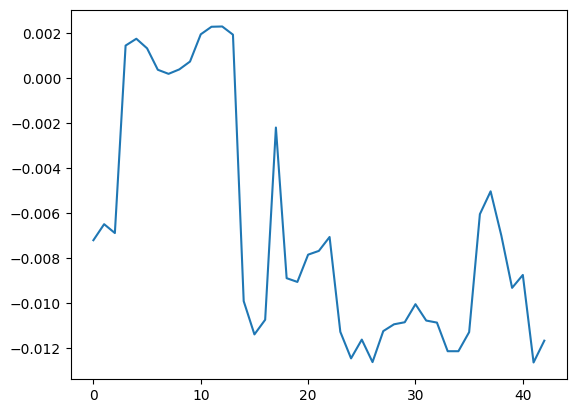

In [24]:
import matplotlib.pyplot as plt
#lows_track["Z_tilt"] = z_tilt
plt.plot(lows_track[lows_track["id"] == 40]["Z_tilt"].values)

In [17]:
lows_track = pd.read_csv("C:/Users/Naveen Kumar/Downloads/major/Lows_variables_Sept02.csv")
lows_track["Z_tilt"] = z_tilt
lows_track.to_csv("C:/Users/Naveen Kumar/Downloads/major/Lows_variables_Sept02.csv")

In [12]:
lows_track[lows_track.index == 1]["Z_tilt"].values

array([-0.02371643, -0.02409515, -0.02345862, -0.02315558, -0.02122878,
       -0.01875075, -0.01377029, -0.0133602 , -0.01331498, -0.01374014,
       -0.00590505, -0.01238987, -0.01746291, -0.02147304, -0.02054733,
       -0.01273632, -0.01253881, -0.00845118, -0.0081183 , -0.00807185,
       -0.0090781 , -0.00956509, -0.01008132, -0.00988381, -0.00950418,
       -0.01663636, -0.01034004, -0.01788231, -0.0071341 , -0.00828899,
       -0.01293625, -0.01293565, -0.01505843, -0.01982752, -0.01612195,
       -0.01487631, -0.01523995, -0.01246404, -0.01264556, -0.01946297,
       -0.0151836 , -0.01604748, -0.013514  , -0.01366597, -0.00511988,
       -0.01257413, -0.01230124, -0.01111772, -0.00665228, -0.00511988,
       -0.0069707 , -0.00683562, -0.00236755, -0.00547058, -0.00633902,
       -0.01104386, -0.0124089 , -0.01315126, -0.01157364, -0.01145243,
       -0.01193699, -0.01240707, -0.01220957, -0.01117833, -0.01525058,
       -0.0120154 , -0.0118182 , -0.01203139, -0.01146993, -0.00

In [55]:
Z999 = xr.open_dataset("C:/Users/Naveen Kumar/Documents/Z999_Lows.nc")

x_vals = Z999['x'].values
y_vals = Z999['y'].values
x, y = np.meshgrid(x_vals, y_vals, indexing='ij')
distance_from_center = np.sqrt(x**2 + y**2)
circle_mask = distance_from_center <= 5
circle_mask_da = xr.DataArray(circle_mask, dims=['x', 'y'], coords={'x': x_vals, 'y': y_vals})

z999 = Z999['snap_Z'].where(circle_mask_da).mean(dim={'x','y'})

Z950 = xr.open_dataset("C:/Users/Naveen Kumar/Documents/Z950_Lows.nc")
z950 = Z950['snap_Z'].where(circle_mask_da).mean(dim={'x','y'})

In [63]:
levels = [100,150,200,250,350,450, 550, 650, 750, 800, 850, 900, 950, 999]
#q = final_data("Q", levels, 5)
#T = final_data("T", levels, 5)
#levels = [100,150,200,250,350,450, 550, 650, 750, 800, 850, 900]
#Z = list(final_data("Z", levels, 5))
#Z=list(Z)
#Z.append(z950)
#Z.append(z999)
#Z=np.array(Z)
cp = 1004 #J (K Kg) ^-1
Lv = 2500000 #J Kg ^ -1

mse = cp*T + Z + Lv*q
    
from scipy.integrate import simpson

integrated_mse = simpson(y=mse, x=levels, axis=0)
lows_track["integrated_mse"] = integrated_mse

In [70]:
lows_track.head()

,Genesis_Date,DateTime,Latitude,Longitude,mslp,VO550,VO750,VO850,PV,Q850,Q850_grad,Q2,US_850,UN_850,VE_850,VW_850,T2,Z_tilt,integrated_mse
id,,,,,,,,,,,,,,,,,,,
1,13-07-1979 02:00,13-07-1979 02:00,26.00,79.75,95.7500,0.000018,0.000019,0.000018,8.309418e-07,0.015136,-0.000367,0.018766,8.954089,-0.285513,0.992574,1.146723,297.532227,-0.019949,3.112617e+08
1,13-07-1979 02:00,13-07-1979 03:00,25.75,79.75,115.5078,0.000019,0.000020,0.000019,8.004154e-07,0.015261,-0.000342,0.018936,8.989159,-0.433509,1.232750,1.141078,298.313995,-0.020344,3.113837e+08
1,13-07-1979 02:00,13-07-1979 04:00,25.75,79.75,115.1016,0.000018,0.000020,0.000020,7.909871e-07,0.015293,-0.000340,0.018936,8.725845,-0.480924,1.515635,1.168594,298.295746,-0.020511,3.114839e+08
1,13-07-1979 02:00,13-07-1979 05:00,25.50,80.00,134.8516,0.000019,0.000022,0.000021,7.549189e-07,0.015409,-0.000320,0.019050,8.751635,-0.493013,1.973333,1.243777,298.841949,-0.021555,3.116334e+08
1,13-07-1979 02:00,13-07-1979 06:00,25.50,80.00,116.0938,0.000018,0.000023,0.000021,7.284822e-07,0.015450,-0.000314,0.019050,8.641402,-0.332411,2.224005,1.401264,299.589478,-0.020641,3.117542e+08


In [72]:
lows_track.to_csv("Lows_processed_data.csv")